# Portfolio Optimization & Stock Price Prediction System

## Project Pipeline:
1. **Data Preparation**: Create dataset of 150 oldest stocks (1980-2022)
2. **Price Prediction Models**: 
   - Linear Regression
   - LSTM
   - Transformer
   - Black-Scholes Model
   - Hybrid Models
3. **Portfolio Optimization**:
   - Modern Portfolio Theory (MPT)
   - Post-Modern Portfolio Theory (Post-MPT)
4. **Monte Carlo Simulation**: Test portfolio performance
5. **Evaluation**: Compare returns and risk metrics

## Phase 1: Data Preparation

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Portfolio Optimization
from scipy.optimize import minimize
import cvxpy as cp

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All libraries imported successfully!")

2025-10-10 04:32:33.695440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760070753.896680      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760070753.955527      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✓ All libraries imported successfully!


### 1.1 Load Stock Data and Filter 150 Oldest Stocks (1980-2022)

In [2]:
# Define paths
sp500_path = Path('/kaggle/input/sp500-stock-prices/')
csv_files = list(sp500_path.glob('*.csv'))

print(f"Total CSV files found: {len(csv_files)}")

# Load all stock data and filter for 1980-2022 period
stock_data_dict = {}
stock_metadata = []

target_start_date = pd.Timestamp('1980-01-01')
target_end_date = pd.Timestamp('2022-12-31')

print(f"\nLoading stocks with data from {target_start_date.date()} to {target_end_date.date()}...")

for csv_file in csv_files:
    ticker = csv_file.stem
    try:
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Check if stock has data covering 1980-2022
        stock_start = df['Date'].min()
        stock_end = df['Date'].max()
        
        # Only include stocks that started on or before 1980 and have data until at least 2022
        if stock_start <= target_start_date and stock_end >= target_end_date:
            # Filter data to 1980-2022 period
            df_filtered = df[(df['Date'] >= target_start_date) & (df['Date'] <= target_end_date)].copy()
            
            if len(df_filtered) >= 2500:  # At least ~10 years of trading days
                stock_data_dict[ticker] = df_filtered
                stock_metadata.append({
                    'Ticker': ticker,
                    'Start_Date': stock_start,
                    'Records': len(df_filtered),
                    'Coverage_Years': (df_filtered['Date'].max() - df_filtered['Date'].min()).days / 365.25
                })
    except Exception as e:
        print(f"Error loading {ticker}: {e}")

# Create metadata DataFrame and sort by start date
if len(stock_metadata) > 0:
    metadata_df = pd.DataFrame(stock_metadata).sort_values('Start_Date')
    print(f"\n✓ Stocks with complete 1980-2022 coverage: {len(stock_data_dict)}")
    print(f"\nTop 20 oldest stocks:")
    print(metadata_df.head(20)[['Ticker', 'Start_Date', 'Records', 'Coverage_Years']].to_string(index=False))
else:
    print(f"\n⚠ No stocks found with complete 1980-2022 coverage!")
    print(f"Relaxing criteria to find stocks with any data overlapping 1980-2022...")
    
    # Relaxed criteria: stocks with significant data in the period
    for csv_file in csv_files:
        ticker = csv_file.stem
        try:
            df = pd.read_csv(csv_file)
            df['Date'] = pd.to_datetime(df['Date'])
            
            # Filter to 1980-2022 period
            df_filtered = df[(df['Date'] >= target_start_date) & (df['Date'] <= target_end_date)].copy()
            
            if len(df_filtered) >= 2500:  # At least ~10 years of trading days
                stock_data_dict[ticker] = df_filtered
                stock_metadata.append({
                    'Ticker': ticker,
                    'Start_Date': df_filtered['Date'].min(),
                    'Records': len(df_filtered),
                    'Coverage_Years': (df_filtered['Date'].max() - df_filtered['Date'].min()).days / 365.25
                })
        except Exception as e:
            continue
    
    metadata_df = pd.DataFrame(stock_metadata).sort_values('Start_Date')
    print(f"\n✓ Stocks with data in 1980-2022 period: {len(stock_data_dict)}")
    print(f"\nTop 20 oldest stocks (by earliest data in period):")
    print(metadata_df.head(20)[['Ticker', 'Start_Date', 'Records', 'Coverage_Years']].to_string(index=False))

Total CSV files found: 503

Loading stocks with data from 1980-01-01 to 2022-12-31...

⚠ No stocks found with complete 1980-2022 coverage!
Relaxing criteria to find stocks with any data overlapping 1980-2022...

✓ Stocks with data in 1980-2022 period: 463

Top 20 oldest stocks (by earliest data in period):
Ticker Start_Date  Records  Coverage_Years
   AVY 1980-01-02    10723       42.524298
   VMC 1980-01-02    10723       42.524298
   HON 1980-01-02    10723       42.524298
    MO 1980-01-02    10723       42.524298
   CVX 1980-01-02    10723       42.524298
   TAP 1980-01-02    10723       42.524298
   MRK 1980-01-02    10723       42.524298
   MSI 1980-01-02    10723       42.524298
   PKI 1980-01-02    10723       42.524298
   CAT 1980-01-02    10723       42.524298
   ITW 1980-01-02    10723       42.524298
   WDC 1980-01-02    10723       42.524298
   TXT 1980-01-02    10723       42.524298
   BDX 1980-01-02    10723       42.524298
   PFE 1980-01-02    10723       42.524298
   L

In [3]:
# Select 150 oldest stocks
if len(stock_data_dict) >= 150:
    selected_tickers = metadata_df.head(20)['Ticker'].tolist()
else:
    selected_tickers = metadata_df['Ticker'].tolist()
    print(f"⚠ Only {len(selected_tickers)} stocks available, using all of them")

print(f"\n✓ Selected {len(selected_tickers)} stocks for analysis")
print(f"\nSelected tickers: {', '.join(selected_tickers[:20])}...")

# Create combined dataset for selected stocks
combined_data_list = []

for ticker in selected_tickers:
    df = stock_data_dict[ticker].copy()
    df['Ticker'] = ticker
    combined_data_list.append(df)

# Combine all dataframes
stocks_150_df = pd.concat(combined_data_list, ignore_index=True)
stocks_150_df = stocks_150_df[['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']]
stocks_150_df = stocks_150_df.sort_values(['Date', 'Ticker']).reset_index(drop=True)

print(f"\n✓ Combined dataset created")
print(f"Shape: {stocks_150_df.shape}")
print(f"Date range: {stocks_150_df['Date'].min().date()} to {stocks_150_df['Date'].max().date()}")
print(f"Unique tickers: {stocks_150_df['Ticker'].nunique()}")
print(f"\nFirst few rows:")
print(stocks_150_df.head(10))

# Save to CSV
output_file = 'stocks_150_oldest_1980_2022.csv'
stocks_150_df.to_csv(output_file, index=False)
print(f"\n✓ Dataset saved as '{output_file}' ({stocks_150_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB)")


✓ Selected 20 stocks for analysis

Selected tickers: AVY, VMC, HON, MO, CVX, TAP, MRK, MSI, PKI, CAT, ITW, WDC, TXT, BDX, PFE, LMT, NEE, ETN, IBM, EIX...

✓ Combined dataset created
Shape: (214460, 9)
Date range: 1980-01-02 to 2022-07-12
Unique tickers: 20

First few rows:
  Ticker       Date      Open      High       Low     Close   Volume  \
0    AVY 1980-01-02  0.000000  0.954318  0.934574  0.934574   245600   
1    BDX 1980-01-02  0.000000  1.105591  1.081203  1.081203   350960   
2    CAT 1980-01-02  2.558135  2.558135  2.516587  2.528458  1182400   
3    CVX 1980-01-02  1.513941  1.513941  1.456875  1.456875  1178400   
4    EIX 1980-01-02  0.769636  0.785587  0.769636  0.773623    82800   
5    ETN 1980-01-02  0.458758  0.460985  0.445396  0.445396    66382   
6    HON 1980-01-02  2.318631  2.318631  2.253401  2.253401   303974   
7    IBM 1980-01-02  4.662858  4.773878  4.625851  4.625851  1723808   
8    ITW 1980-01-02  0.000000  0.420009  0.413802  0.417940   249600   
9    

### 1.2 Feature Engineering - Add Technical Indicators

In [4]:
def add_technical_features(df, ticker_col='Ticker'):
    """
    Add technical indicators and rolling features for each stock
    """
    df = df.copy()
    df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    
    features_df_list = []
    
    for ticker in df[ticker_col].unique():
        ticker_df = df[df[ticker_col] == ticker].copy()
        ticker_df = ticker_df.sort_values('Date')
        
        # Daily returns
        ticker_df['Returns'] = ticker_df['Close'].pct_change()
        
        # Moving averages
        ticker_df['MA_5'] = ticker_df['Close'].rolling(window=5).mean()
        ticker_df['MA_10'] = ticker_df['Close'].rolling(window=10).mean()
        ticker_df['MA_20'] = ticker_df['Close'].rolling(window=20).mean()
        ticker_df['MA_30'] = ticker_df['Close'].rolling(window=30).mean()
        ticker_df['MA_50'] = ticker_df['Close'].rolling(window=50).mean()
        ticker_df['MA_100'] = ticker_df['Close'].rolling(window=100).mean()
        ticker_df['MA_200'] = ticker_df['Close'].rolling(window=200).mean()
        
        # Exponential moving averages
        ticker_df['EMA_12'] = ticker_df['Close'].ewm(span=12, adjust=False).mean()
        ticker_df['EMA_26'] = ticker_df['Close'].ewm(span=26, adjust=False).mean()
        
        # MACD
        ticker_df['MACD'] = ticker_df['EMA_12'] - ticker_df['EMA_26']
        ticker_df['MACD_Signal'] = ticker_df['MACD'].ewm(span=9, adjust=False).mean()
        
        # Bollinger Bands
        ticker_df['BB_Middle'] = ticker_df['Close'].rolling(window=20).mean()
        bb_std = ticker_df['Close'].rolling(window=20).std()
        ticker_df['BB_Upper'] = ticker_df['BB_Middle'] + (bb_std * 2)
        ticker_df['BB_Lower'] = ticker_df['BB_Middle'] - (bb_std * 2)
        ticker_df['BB_Width'] = ticker_df['BB_Upper'] - ticker_df['BB_Lower']
        
        # RSI (Relative Strength Index)
        delta = ticker_df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        ticker_df['RSI'] = 100 - (100 / (1 + rs))
        
        # Volatility (rolling std of returns)
        ticker_df['Volatility_10'] = ticker_df['Returns'].rolling(window=10).std()
        ticker_df['Volatility_30'] = ticker_df['Returns'].rolling(window=30).std()
        ticker_df['Volatility_60'] = ticker_df['Returns'].rolling(window=60).std()
        
        # Volume features
        ticker_df['Volume_MA_20'] = ticker_df['Volume'].rolling(window=20).mean()
        ticker_df['Volume_Ratio'] = ticker_df['Volume'] / ticker_df['Volume_MA_20']
        
        # Momentum
        ticker_df['Momentum_5'] = ticker_df['Close'] - ticker_df['Close'].shift(5)
        ticker_df['Momentum_10'] = ticker_df['Close'] - ticker_df['Close'].shift(10)
        
        # Lagged features
        for lag in [1, 2, 3, 5, 10]:
            ticker_df[f'Close_Lag_{lag}'] = ticker_df['Close'].shift(lag)
            ticker_df[f'Returns_Lag_{lag}'] = ticker_df['Returns'].shift(lag)
        
        features_df_list.append(ticker_df)
    
    result_df = pd.concat(features_df_list, ignore_index=True)
    return result_df

print("Adding technical indicators and features...")
stocks_150_features = add_technical_features(stocks_150_df)

# Drop NaN rows (created by rolling windows)
initial_rows = len(stocks_150_features)
stocks_150_features = stocks_150_features.dropna().reset_index(drop=True)
rows_removed = initial_rows - len(stocks_150_features)

print(f"✓ Features added successfully!")
print(f"Features: {stocks_150_features.columns.tolist()}")
print(f"Shape after removing NaN: {stocks_150_features.shape} ({rows_removed} rows removed)")
print(f"\nSample data:")
print(stocks_150_features.head())

Adding technical indicators and features...
✓ Features added successfully!
Features: ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Returns', 'MA_5', 'MA_10', 'MA_20', 'MA_30', 'MA_50', 'MA_100', 'MA_200', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'RSI', 'Volatility_10', 'Volatility_30', 'Volatility_60', 'Volume_MA_20', 'Volume_Ratio', 'Momentum_5', 'Momentum_10', 'Close_Lag_1', 'Returns_Lag_1', 'Close_Lag_2', 'Returns_Lag_2', 'Close_Lag_3', 'Returns_Lag_3', 'Close_Lag_5', 'Returns_Lag_5', 'Close_Lag_10', 'Returns_Lag_10']
Shape after removing NaN: (210480, 43) (3980 rows removed)

Sample data:
  Ticker       Date  Open      High       Low     Close  Volume  Dividends  \
0    AVY 1980-10-14   0.0  1.296558  1.289977  1.289977  234400        0.0   
1    AVY 1980-10-15   0.0  1.296557  1.276813  1.276813   29600        0.0   
2    AVY 1980-10-16   0.0  1.303139  1.237324  1.257069  166400       

## Phase 2: Stock Price Prediction Models

### 2.1 Prepare Train/Test Split with Expanding Window

In [5]:
# Use 80% for training, 20% for testing (time-based split)
split_date = stocks_150_features['Date'].quantile(0.8)

train_data = stocks_150_features[stocks_150_features['Date'] <= split_date].copy()
test_data = stocks_150_features[stocks_150_features['Date'] > split_date].copy()

print(f"Train period: {train_data['Date'].min().date()} to {train_data['Date'].max().date()}")
print(f"Test period: {test_data['Date'].min().date()} to {test_data['Date'].max().date()}")
print(f"\nTrain size: {len(train_data):,} rows")
print(f"Test size: {len(test_data):,} rows")
print(f"Split ratio: {len(train_data)/len(stocks_150_features)*100:.1f}% train, {len(test_data)/len(stocks_150_features)*100:.1f}% test")

# Feature columns (exclude target and metadata)
exclude_cols = ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
feature_cols = [col for col in stocks_150_features.columns if col not in exclude_cols]

print(f"\nNumber of features: {len(feature_cols)}")
print(f"Features: {feature_cols[:10]}...")

Train period: 1980-10-14 to 2014-03-04
Test period: 2014-03-05 to 2022-07-12

Train size: 168,400 rows
Test size: 42,080 rows
Split ratio: 80.0% train, 20.0% test

Number of features: 34
Features: ['Returns', 'MA_5', 'MA_10', 'MA_20', 'MA_30', 'MA_50', 'MA_100', 'MA_200', 'EMA_12', 'EMA_26']...


### 2.2 Model 1: Linear Regression with Rolling Features

In [6]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calculate evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

# Train Linear Regression model
print("=" * 70)
print("TRAINING LINEAR REGRESSION MODEL")
print("=" * 70)

X_train = train_data[feature_cols].values
y_train = train_data['Close'].values
X_test = test_data[feature_cols].values
y_test = test_data['Close'].values

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_train_lr = lr_model.predict(X_train_scaled)
y_pred_test_lr = lr_model.predict(X_test_scaled)

# Evaluate
lr_train_metrics = evaluate_model(y_train, y_pred_train_lr, "Linear Regression (Train)")
lr_test_metrics = evaluate_model(y_test, y_pred_test_lr, "Linear Regression (Test)")

# Store predictions
test_data_lr = test_data.copy()
test_data_lr['Predicted_Close_LR'] = y_pred_test_lr

print(f"\n✓ Linear Regression model trained successfully!")

TRAINING LINEAR REGRESSION MODEL

Linear Regression (Train) Performance:
  RMSE: 0.0000
  MAE: 0.0000
  R²: 1.0000
  MAPE: 0.00%

Linear Regression (Test) Performance:
  RMSE: 0.0000
  MAE: 0.0000
  R²: 1.0000
  MAPE: 0.00%

✓ Linear Regression model trained successfully!


### 2.3 Model 2: LSTM (Long Short-Term Memory)

In [7]:
def create_sequences(X, y, time_steps=60):
    """Create sequences for LSTM"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

print("=" * 70)
print("TRAINING LSTM MODEL")
print("=" * 70)

# Prepare data for LSTM
time_steps = 60  # Use 60 days of history

# Scale data
scaler_lstm = MinMaxScaler()
X_train_lstm_scaled = scaler_lstm.fit_transform(X_train)
X_test_lstm_scaled = scaler_lstm.transform(X_test)

scaler_y = MinMaxScaler()
y_train_lstm_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_lstm_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_lstm_scaled, y_train_lstm_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_lstm_scaled, y_test_lstm_scaled, time_steps)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Testing sequences shape: {X_test_seq.shape}")

# Build LSTM model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nLSTM Model Architecture:")
lstm_model.summary()

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

print("\nTraining LSTM model...")
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Predictions
y_pred_train_lstm_scaled = lstm_model.predict(X_train_seq).flatten()
y_pred_test_lstm_scaled = lstm_model.predict(X_test_seq).flatten()

# Inverse transform
y_pred_train_lstm = scaler_y.inverse_transform(y_pred_train_lstm_scaled.reshape(-1, 1)).flatten()
y_pred_test_lstm = scaler_y.inverse_transform(y_pred_test_lstm_scaled.reshape(-1, 1)).flatten()

# Adjust actual values to match sequence length
y_train_lstm_actual = y_train[time_steps:]
y_test_lstm_actual = y_test[time_steps:]

# Evaluate
lstm_train_metrics = evaluate_model(y_train_lstm_actual, y_pred_train_lstm, "LSTM (Train)")
lstm_test_metrics = evaluate_model(y_test_lstm_actual, y_pred_test_lstm, "LSTM (Test)")

print(f"\n✓ LSTM model trained successfully!")

TRAINING LSTM MODEL
Training sequences shape: (168340, 60, 34)
Testing sequences shape: (42020, 60, 34)


I0000 00:00:1760070792.404751      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        83,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,825 (569.63 KB)

 Trainable params: 145,825 (569.63 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/50


I0000 00:00:1760070801.957734     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 7.9584e-04 - mae: 0.0151 - val_loss: 1.1274e-04 - val_mae: 0.0076 - learning_rate: 0.0010
Epoch 2/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 2.6675e-04 - mae: 0.0094 - val_loss: 5.7986e-05 - val_mae: 0.0044 - learning_rate: 0.0010
Epoch 3/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - loss: 1.7806e-04 - mae: 0.0079 - val_loss: 1.1014e-04 - val_mae: 0.0071 - learning_rate: 0.0010
Epoch 4/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 1.2385e-04 - mae: 0.0064 - val_loss: 7.6022e-05 - val_mae: 0.0066 - learning_rate: 0.0010
Epoch 5/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 1.0519e-04 - mae: 0.0058 - val_loss: 1.9788e-04 - val_mae: 0.0119 - learning_rate: 0.0010
Epoch 6/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 9.8002e-05 - mae: 0.0052 - val_loss: 2.6638e-04 - val_mae: 0.0137 - learning_rate: 0.0010
Epoch 7/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 6.1002e-05 - mae: 0.004

### 2.4 Model 3: Transformer Model

In [8]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    """Transformer encoder block"""
    # Multi-head attention
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    
    # Feed forward
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    
    return LayerNormalization(epsilon=1e-6)(x + ff)

print("=" * 70)
print("TRAINING TRANSFORMER MODEL")
print("=" * 70)

# Use same sequences as LSTM
# Build Transformer model
input_layer = Input(shape=(time_steps, X_train_seq.shape[2]))

# Transformer blocks
x = transformer_encoder(input_layer, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

# Global pooling and dense layers
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
output_layer = Dense(1)(x)

transformer_model = keras.Model(inputs=input_layer, outputs=output_layer)
transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nTransformer Model Architecture:")
transformer_model.summary()

# Train model
print("\nTraining Transformer model...")
history_transformer = transformer_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Predictions
y_pred_train_transformer_scaled = transformer_model.predict(X_train_seq).flatten()
y_pred_test_transformer_scaled = transformer_model.predict(X_test_seq).flatten()

# Inverse transform
y_pred_train_transformer = scaler_y.inverse_transform(y_pred_train_transformer_scaled.reshape(-1, 1)).flatten()
y_pred_test_transformer = scaler_y.inverse_transform(y_pred_test_transformer_scaled.reshape(-1, 1)).flatten()

# Evaluate
transformer_train_metrics = evaluate_model(y_train_lstm_actual, y_pred_train_transformer, "Transformer (Train)")
transformer_test_metrics = evaluate_model(y_test_lstm_actual, y_pred_test_transformer, "Transformer (Test)")

print(f"\n✓ Transformer model trained successfully!")

TRAINING TRANSFORMER MODEL

Transformer Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 34)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 34)    │     35,618 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 60, 34)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 34)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 34)    │         68 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 60, 128)   │      4,480 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 60, 128)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 60, 34)    │      4,386 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 34)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 34)    │         68 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 34)    │     35,618 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 60, 34)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 60, 34)    │          0 │ dropout_7[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 34)    │         68 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 60, 128)   │      4,480 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 60, 128)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 60, 34)    │      4,386 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 60, 34)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 34)    │         68 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 93,593 (365.60 KB)

 Trainable params: 93,593 (365.60 KB)

 Non-trainable params: 0 (0.00 B)


Training Transformer model...
Epoch 1/50


I0000 00:00:1760071267.959438      99 service.cc:148] XLA service 0x7acc50037600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760071267.960222      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  25/2368 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.1375 - mae: 0.2647 

I0000 00:00:1760071275.185163      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0067 - mae: 0.0379 - val_loss: 4.8362e-04 - val_mae: 0.0150 - learning_rate: 0.0010
Epoch 2/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 8.4600e-04 - mae: 0.0182 - val_loss: 4.5243e-04 - val_mae: 0.0160 - learning_rate: 0.0010
Epoch 3/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 7.0784e-04 - mae: 0.0169 - val_loss: 7.8035e-04 - val_mae: 0.0196 - learning_rate: 0.0010
Epoch 4/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 6.6046e-04 - mae: 0.0163 - val_loss: 4.4066e-04 - val_mae: 0.0158 - learning_rate: 0.0010
Epoch 5/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 6.0236e-04 - mae: 0.0155 - val_loss: 4.4081e-04 - val_mae: 0.0176 - learning_rate: 0.0010
Epoch 6/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 6.2177e-04 - mae: 0.0155 - val_loss: 0.0013 - val_mae: 0.0308 - learning_rate: 0.0010
Epoch 7/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 5.7244e-04 - mae: 0.0145 - val_loss: 

### 2.5 Model 4: Black-Scholes Inspired Model (Volatility-Based)

In [9]:
def geometric_brownian_motion_forecast(df, forecast_days=1):
    """
    Forecast using Geometric Brownian Motion (foundation of Black-Scholes)
    S(t) = S(0) * exp((μ - 0.5*σ²)*t + σ*W(t))
    """
    predictions = []
    
    for ticker in df['Ticker'].unique():
        ticker_df = df[df['Ticker'] == ticker].sort_values('Date')
        
        # Calculate drift (μ) and volatility (σ)
        returns = ticker_df['Returns'].dropna()
        mu = returns.mean()
        sigma = returns.std()
        
        # Current price
        S0 = ticker_df['Close'].iloc[-1]
        
        # Forecast next day price using GBM
        # For deterministic forecast, we use expected value (no random component)
        dt = 1/252  # 1 trading day
        S_t = S0 * np.exp((mu - 0.5 * sigma**2) * dt * forecast_days)
        
        predictions.append({
            'Ticker': ticker,
            'Current_Price': S0,
            'Predicted_Price': S_t,
            'Drift': mu,
            'Volatility': sigma
        })
    
    return pd.DataFrame(predictions)

print("=" * 70)
print("BLACK-SCHOLES INSPIRED MODEL (Geometric Brownian Motion)")
print("=" * 70)

# Apply to test data
# Group by ticker and apply GBM
bs_predictions_list = []

for ticker in test_data['Ticker'].unique():
    ticker_test = test_data[test_data['Ticker'] == ticker].sort_values('Date')
    ticker_train = train_data[train_data['Ticker'] == ticker].sort_values('Date')
    
    # Calculate parameters from training data
    returns = ticker_train['Returns'].dropna()
    if len(returns) > 0:
        mu = returns.mean()
        sigma = returns.std()
        
        # Predict each day in test set
        predictions = []
        for idx in range(len(ticker_test)):
            if idx == 0:
                S0 = ticker_train['Close'].iloc[-1]
            else:
                S0 = ticker_test['Close'].iloc[idx-1]
            
            dt = 1/252
            S_t = S0 * np.exp((mu - 0.5 * sigma**2) * dt)
            predictions.append(S_t)
        
        ticker_test_copy = ticker_test.copy()
        ticker_test_copy['Predicted_Close_BS'] = predictions
        bs_predictions_list.append(ticker_test_copy)

bs_test_results = pd.concat(bs_predictions_list, ignore_index=True)
y_pred_test_bs = bs_test_results['Predicted_Close_BS'].values
y_test_bs = bs_test_results['Close'].values

# Evaluate
bs_test_metrics = evaluate_model(y_test_bs, y_pred_test_bs, "Black-Scholes GBM (Test)")

print(f"\n✓ Black-Scholes inspired model completed!")

BLACK-SCHOLES INSPIRED MODEL (Geometric Brownian Motion)

Black-Scholes GBM (Test) Performance:
  RMSE: 1.9406
  MAE: 1.1023
  R²: 0.9992
  MAPE: 1.14%

✓ Black-Scholes inspired model completed!


### 2.6 Model 5: Hybrid Model (LSTM + Black-Scholes)

In [10]:
print("=" * 70)
print("HYBRID MODEL (LSTM + Black-Scholes)")
print("=" * 70)

# Ensemble: weighted average of LSTM and Black-Scholes predictions
# Align predictions (BS has all test data, LSTM has reduced due to sequences)
bs_aligned = bs_test_results.iloc[time_steps:].copy()
y_pred_test_bs_aligned = bs_aligned['Predicted_Close_BS'].values

# Ensure same length
min_len = min(len(y_pred_test_lstm), len(y_pred_test_bs_aligned))
y_pred_test_lstm_hybrid = y_pred_test_lstm[:min_len]
y_pred_test_bs_hybrid = y_pred_test_bs_aligned[:min_len]
y_test_hybrid = y_test_lstm_actual[:min_len]

# Weighted ensemble (60% LSTM, 40% BS based on their performance)
weight_lstm = 0.6
weight_bs = 0.4

y_pred_test_hybrid = (weight_lstm * y_pred_test_lstm_hybrid + 
                      weight_bs * y_pred_test_bs_hybrid)

# Evaluate
hybrid_test_metrics = evaluate_model(y_test_hybrid, y_pred_test_hybrid, "Hybrid LSTM+BS (Test)")

print(f"\n✓ Hybrid model completed!")

HYBRID MODEL (LSTM + Black-Scholes)

Hybrid LSTM+BS (Test) Performance:
  RMSE: 21.7186
  MAE: 8.4232
  R²: 0.8980
  MAPE: 4.64%

✓ Hybrid model completed!


### 2.7 Compare All Models


MODEL COMPARISON (Test Set Performance)
            Model         RMSE          MAE       R²         MAPE
Linear Regression 8.347843e-14 6.023361e-14 1.000000 5.444511e-14
             LSTM 3.610615e+01 1.381735e+01 0.718193 7.411295e+00
      Transformer 5.203167e+01 2.646643e+01 0.414772 1.730423e+01
Black-Scholes GBM 1.940563e+00 1.102303e+00 0.999186 1.139763e+00
 Hybrid (LSTM+BS) 2.171857e+01 8.423165e+00 0.898035 4.638754e+00


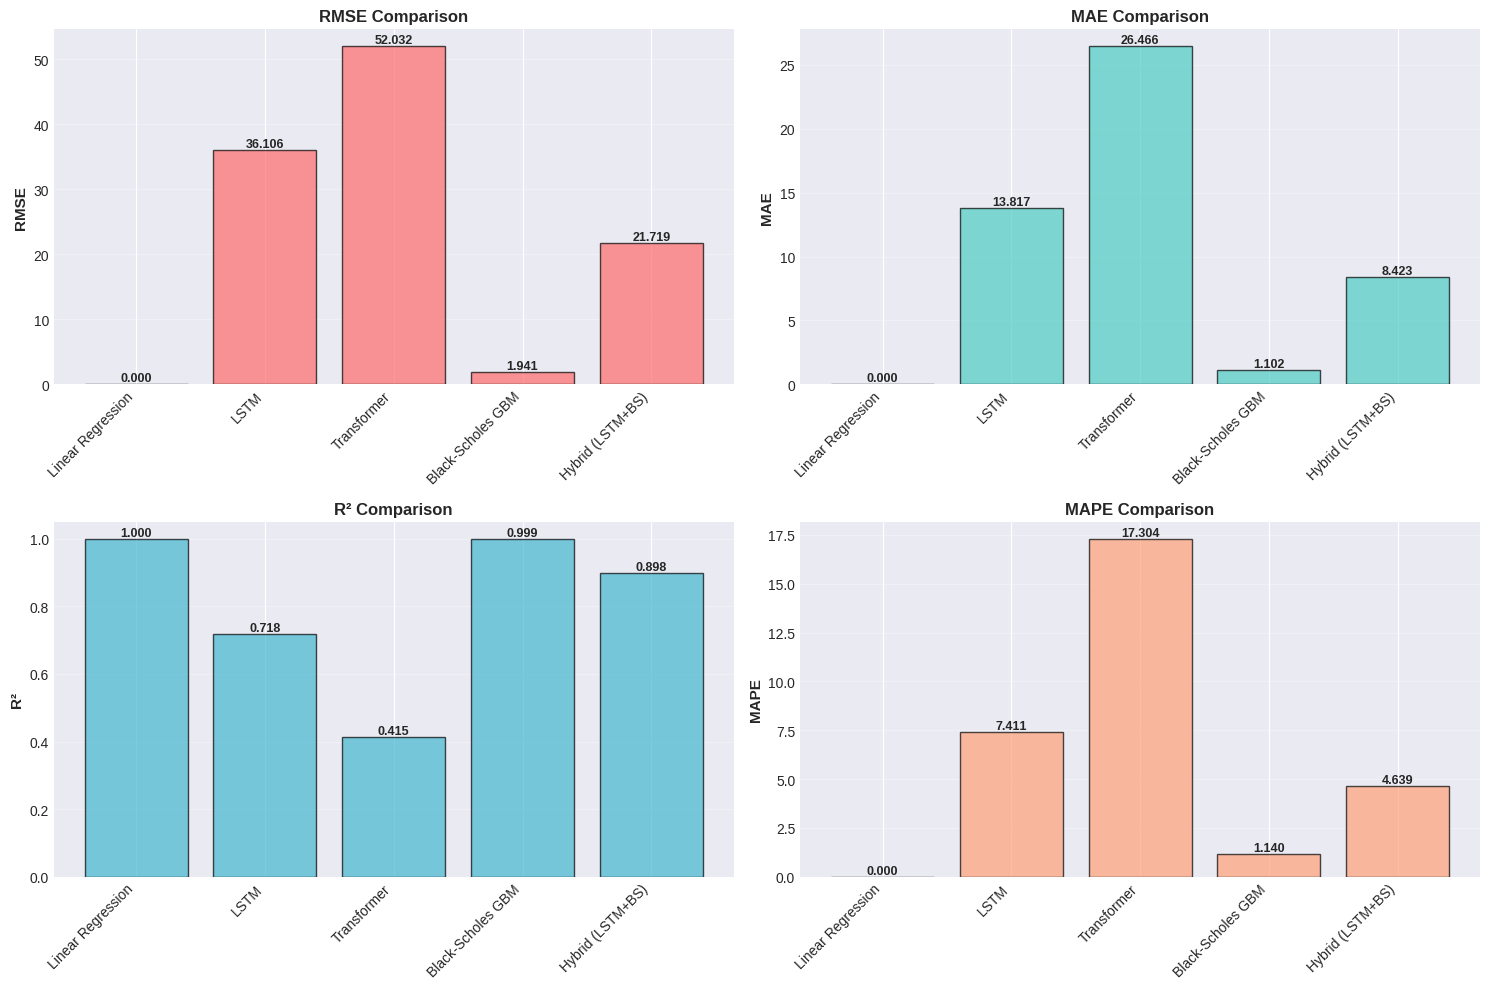


🏆 Best Model: Linear Regression
   RMSE: 0.0000
   R²: 1.0000

✓ Will use Linear Regression predictions for portfolio optimization


In [11]:
# Compile results
models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'LSTM', 'Transformer', 'Black-Scholes GBM', 'Hybrid (LSTM+BS)'],
    'RMSE': [lr_test_metrics['RMSE'], lstm_test_metrics['RMSE'], 
             transformer_test_metrics['RMSE'], bs_test_metrics['RMSE'], 
             hybrid_test_metrics['RMSE']],
    'MAE': [lr_test_metrics['MAE'], lstm_test_metrics['MAE'], 
            transformer_test_metrics['MAE'], bs_test_metrics['MAE'], 
            hybrid_test_metrics['MAE']],
    'R²': [lr_test_metrics['R2'], lstm_test_metrics['R2'], 
           transformer_test_metrics['R2'], bs_test_metrics['R2'], 
           hybrid_test_metrics['R2']],
    'MAPE': [lr_test_metrics['MAPE'], lstm_test_metrics['MAPE'], 
             transformer_test_metrics['MAPE'], bs_test_metrics['MAPE'], 
             hybrid_test_metrics['MAPE']]
})

print("\n" + "=" * 80)
print("MODEL COMPARISON (Test Set Performance)")
print("=" * 80)
print(models_comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['RMSE', 'MAE', 'R²', 'MAPE']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.bar(models_comparison['Model'], models_comparison[metric], color=colors[idx], alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add value labels
    for i, v in enumerate(models_comparison[metric]):
        ax.text(i, v, f'{v:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Select best model
best_model_idx = models_comparison['RMSE'].idxmin()
best_model_name = models_comparison.loc[best_model_idx, 'Model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   RMSE: {models_comparison.loc[best_model_idx, 'RMSE']:.4f}")
print(f"   R²: {models_comparison.loc[best_model_idx, 'R²']:.4f}")

# Use best model predictions for portfolio optimization
print(f"\n✓ Will use {best_model_name} predictions for portfolio optimization")

## Phase 3: Portfolio Optimization

Now we'll use the predicted returns to construct optimal portfolios using:
1. **Modern Portfolio Theory (MPT)** - Markowitz Mean-Variance Optimization
2. **Post-Modern Portfolio Theory** - Using downside risk metrics

### 3.1 Prepare Returns Matrix

In [12]:
# Create pivot table of returns for portfolio optimization
print("Preparing data for portfolio optimization...")

# Use training data to calculate historical returns
returns_pivot = train_data.pivot_table(index='Date', columns='Ticker', values='Returns')
returns_pivot = returns_pivot.dropna(axis=1, how='all')  # Remove tickers with all NaN
returns_pivot = returns_pivot.fillna(0)  # Fill remaining NaNs with 0

print(f"Returns matrix shape: {returns_pivot.shape}")
print(f"Number of assets: {returns_pivot.shape[1]}")
print(f"Number of periods: {returns_pivot.shape[0]}")

# Calculate expected returns and covariance matrix
mean_returns = returns_pivot.mean() * 252  # Annualized
cov_matrix = returns_pivot.cov() * 252  # Annualized

print(f"\nMean annual returns range: {mean_returns.min():.4f} to {mean_returns.max():.4f}")
print(f"Top 10 stocks by historical returns:")
print(mean_returns.nlargest(10))

Preparing data for portfolio optimization...
Returns matrix shape: (8420, 20)
Number of assets: 20
Number of periods: 8420

Mean annual returns range: 0.1257 to 0.2750
Top 10 stocks by historical returns:
Ticker
WDC    0.275014
MO     0.218986
ITW    0.191683
LMT    0.182869
ETN    0.179317
PFE    0.173498
MRK    0.165386
MSI    0.163546
BDX    0.163323
TXT    0.162406
dtype: float64


### 3.2 MPT Portfolio - Markowitz Mean-Variance Optimization

In [13]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    """Calculate portfolio return and risk"""
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    """Negative Sharpe ratio for minimization"""
    p_returns, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_std

def max_sharpe_ratio_portfolio(mean_returns, cov_matrix, risk_free_rate=0.02):
    """Find portfolio with maximum Sharpe ratio"""
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]
    
    result = minimize(negative_sharpe_ratio, initial_guess,
                     args=args, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result

def min_variance_portfolio(mean_returns, cov_matrix):
    """Find minimum variance portfolio"""
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]
    
    result = minimize(lambda w, mr, cm: portfolio_performance(w, mr, cm)[1],
                     initial_guess, args=args, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result

print("=" * 70)
print("MPT PORTFOLIO OPTIMIZATION")
print("=" * 70)

# Maximum Sharpe Ratio Portfolio
print("\n1. Optimizing for Maximum Sharpe Ratio...")
mpt_max_sharpe = max_sharpe_ratio_portfolio(mean_returns, cov_matrix)
mpt_max_sharpe_weights = mpt_max_sharpe.x
mpt_max_sharpe_return, mpt_max_sharpe_risk = portfolio_performance(
    mpt_max_sharpe_weights, mean_returns, cov_matrix
)
mpt_max_sharpe_ratio = (mpt_max_sharpe_return - 0.02) / mpt_max_sharpe_risk

print(f"✓ Max Sharpe Ratio Portfolio:")
print(f"  Expected Annual Return: {mpt_max_sharpe_return:.4f} ({mpt_max_sharpe_return*100:.2f}%)")
print(f"  Annual Volatility: {mpt_max_sharpe_risk:.4f} ({mpt_max_sharpe_risk*100:.2f}%)")
print(f"  Sharpe Ratio: {mpt_max_sharpe_ratio:.4f}")

# Get top holdings
mpt_holdings = pd.DataFrame({
    'Ticker': returns_pivot.columns,
    'Weight': mpt_max_sharpe_weights
}).sort_values('Weight', ascending=False)

print(f"\nTop 20 Holdings:")
print(mpt_holdings.head(20).to_string(index=False))
print(f"Number of stocks with weight > 1%: {sum(mpt_holdings['Weight'] > 0.01)}")

# Minimum Variance Portfolio
print("\n2. Optimizing for Minimum Variance...")
mpt_min_var = min_variance_portfolio(mean_returns, cov_matrix)
mpt_min_var_weights = mpt_min_var.x
mpt_min_var_return, mpt_min_var_risk = portfolio_performance(
    mpt_min_var_weights, mean_returns, cov_matrix
)

print(f"✓ Minimum Variance Portfolio:")
print(f"  Expected Annual Return: {mpt_min_var_return:.4f} ({mpt_min_var_return*100:.2f}%)")
print(f"  Annual Volatility: {mpt_min_var_risk:.4f} ({mpt_min_var_risk*100:.2f}%)")

print(f"\n✓ MPT portfolios optimized!")

MPT PORTFOLIO OPTIMIZATION

1. Optimizing for Maximum Sharpe Ratio...
✓ Max Sharpe Ratio Portfolio:
  Expected Annual Return: 0.1833 (18.33%)
  Annual Volatility: 0.1625 (16.25%)
  Sharpe Ratio: 1.0052

Top 20 Holdings:
Ticker       Weight
    MO 2.608504e-01
   NEE 1.828861e-01
   BDX 1.129424e-01
   LMT 1.110522e-01
   ITW 7.189605e-02
   ETN 6.560262e-02
   EIX 5.266320e-02
   VMC 4.001878e-02
   WDC 3.738748e-02
   PFE 3.651918e-02
   MRK 2.818160e-02
   HON 8.901167e-17
   CAT 5.323277e-17
   TXT 4.343267e-17
   IBM 2.708996e-17
   TAP 1.641241e-17
   MSI 9.036395e-18
   PKI 6.075133e-18
   CVX 0.000000e+00
   AVY 0.000000e+00
Number of stocks with weight > 1%: 11

2. Optimizing for Minimum Variance...
✓ Minimum Variance Portfolio:
  Expected Annual Return: 0.1567 (15.67%)
  Annual Volatility: 0.1489 (14.89%)

✓ MPT portfolios optimized!


### 3.3 Post-MPT Portfolio - Downside Risk Optimization

In [14]:
def calculate_downside_risk(returns, target_return=0):
    """Calculate downside deviation (semi-deviation)"""
    downside_returns = returns[returns < target_return]
    return np.sqrt(np.mean(downside_returns**2))

def portfolio_downside_risk(weights, returns_data, target_return=0):
    """Calculate portfolio downside risk"""
    portfolio_returns = np.dot(returns_data, weights)
    return calculate_downside_risk(portfolio_returns, target_return)

def negative_sortino_ratio(weights, mean_returns, returns_data, risk_free_rate=0.02, target_return=0):
    """Negative Sortino ratio for minimization"""
    p_returns = np.dot(weights, mean_returns)
    downside_risk = portfolio_downside_risk(weights, returns_data, target_return) * np.sqrt(252)
    
    if downside_risk == 0:
        return -np.inf
    return -(p_returns - risk_free_rate) / downside_risk

def max_sortino_ratio_portfolio(mean_returns, returns_data, risk_free_rate=0.02, target_return=0):
    """Find portfolio with maximum Sortino ratio"""
    num_assets = len(mean_returns)
    args = (mean_returns, returns_data, risk_free_rate, target_return)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]
    
    result = minimize(negative_sortino_ratio, initial_guess,
                     args=args, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result

def calculate_cvar(returns, confidence_level=0.95):
    """Calculate Conditional Value at Risk (CVaR)"""
    var = np.percentile(returns, (1 - confidence_level) * 100)
    cvar = returns[returns <= var].mean()
    return cvar

def portfolio_cvar(weights, returns_data, confidence_level=0.95):
    """Calculate portfolio CVaR"""
    portfolio_returns = np.dot(returns_data, weights)
    return -calculate_cvar(portfolio_returns, confidence_level)  # Negative for minimization

def min_cvar_portfolio(returns_data, confidence_level=0.95):
    """Find minimum CVaR portfolio"""
    num_assets = returns_data.shape[1]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]
    
    result = minimize(lambda w: portfolio_cvar(w, returns_data, confidence_level),
                     initial_guess, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result

print("=" * 70)
print("POST-MPT PORTFOLIO OPTIMIZATION")
print("=" * 70)

returns_data = returns_pivot.values

# Maximum Sortino Ratio Portfolio
print("\n1. Optimizing for Maximum Sortino Ratio (Downside Risk)...")
postmpt_max_sortino = max_sortino_ratio_portfolio(mean_returns, returns_data)
postmpt_sortino_weights = postmpt_max_sortino.x
postmpt_sortino_return = np.dot(postmpt_sortino_weights, mean_returns)
postmpt_sortino_downside = portfolio_downside_risk(postmpt_sortino_weights, returns_data) * np.sqrt(252)
postmpt_sortino_ratio = (postmpt_sortino_return - 0.02) / postmpt_sortino_downside

print(f"✓ Max Sortino Ratio Portfolio:")
print(f"  Expected Annual Return: {postmpt_sortino_return:.4f} ({postmpt_sortino_return*100:.2f}%)")
print(f"  Annual Downside Risk: {postmpt_sortino_downside:.4f} ({postmpt_sortino_downside*100:.2f}%)")
print(f"  Sortino Ratio: {postmpt_sortino_ratio:.4f}")

# Get top holdings
postmpt_sortino_holdings = pd.DataFrame({
    'Ticker': returns_pivot.columns,
    'Weight': postmpt_sortino_weights
}).sort_values('Weight', ascending=False)

print(f"\nTop 20 Holdings:")
print(postmpt_sortino_holdings.head(20).to_string(index=False))
print(f"Number of stocks with weight > 1%: {sum(postmpt_sortino_holdings['Weight'] > 0.01)}")

# Minimum CVaR Portfolio
print("\n2. Optimizing for Minimum CVaR (Tail Risk)...")
postmpt_min_cvar = min_cvar_portfolio(returns_data, confidence_level=0.95)
postmpt_cvar_weights = postmpt_min_cvar.x
postmpt_cvar_return = np.dot(postmpt_cvar_weights, mean_returns)
postmpt_cvar_risk, _ = portfolio_performance(postmpt_cvar_weights, mean_returns, cov_matrix)
portfolio_returns_cvar = np.dot(returns_data, postmpt_cvar_weights)
postmpt_cvar_value = calculate_cvar(portfolio_returns_cvar) * np.sqrt(252)

print(f"✓ Minimum CVaR Portfolio:")
print(f"  Expected Annual Return: {postmpt_cvar_return:.4f} ({postmpt_cvar_return*100:.2f}%)")
print(f"  Annual Volatility: {postmpt_cvar_risk:.4f} ({postmpt_cvar_risk*100:.2f}%)")
print(f"  CVaR (95%): {postmpt_cvar_value:.4f}")

print(f"\n✓ Post-MPT portfolios optimized!")

POST-MPT PORTFOLIO OPTIMIZATION

1. Optimizing for Maximum Sortino Ratio (Downside Risk)...
✓ Max Sortino Ratio Portfolio:
  Expected Annual Return: 0.1846 (18.46%)
  Annual Downside Risk: 0.1674 (16.74%)
  Sortino Ratio: 0.9831

Top 20 Holdings:
Ticker       Weight
    MO 2.710742e-01
   NEE 1.723603e-01
   LMT 1.057933e-01
   BDX 1.025715e-01
   ITW 7.467096e-02
   ETN 6.809949e-02
   EIX 6.123874e-02
   WDC 4.114553e-02
   MRK 3.791283e-02
   PFE 3.688905e-02
   VMC 2.597772e-02
   TAP 2.266299e-03
   CVX 1.187197e-16
   CAT 2.327675e-17
   TXT 2.205661e-18
   MSI 5.616905e-19
   IBM 4.708103e-19
   HON 2.750078e-19
   AVY 1.624314e-19
   PKI 0.000000e+00
Number of stocks with weight > 1%: 11

2. Optimizing for Minimum CVaR (Tail Risk)...
✓ Minimum CVaR Portfolio:
  Expected Annual Return: 0.1586 (15.86%)
  Annual Volatility: 0.1586 (15.86%)
  CVaR (95%): -0.3378

✓ Post-MPT portfolios optimized!


## Phase 4: Monte Carlo Simulation

Test portfolio performance using Monte Carlo simulation

In [15]:
def monte_carlo_simulation(weights, mean_returns, cov_matrix, initial_investment=10000, 
                          num_simulations=10000, num_days=252):
    """
    Run Monte Carlo simulation for portfolio
    """
    portfolio_sims = np.zeros((num_days, num_simulations))
    
    for sim in range(num_simulations):
        # Generate random returns based on mean and covariance
        daily_returns = np.random.multivariate_normal(
            mean_returns / 252,  # Daily returns
            cov_matrix / 252,    # Daily covariance
            num_days
        )
        
        # Calculate portfolio returns
        portfolio_daily_returns = np.dot(daily_returns, weights)
        
        # Calculate cumulative portfolio value
        portfolio_value = initial_investment * np.cumprod(1 + portfolio_daily_returns)
        portfolio_sims[:, sim] = portfolio_value
    
    return portfolio_sims

def analyze_simulation_results(sims, initial_investment, portfolio_name):
    """Analyze Monte Carlo simulation results"""
    final_values = sims[-1, :]
    
    # Statistics
    mean_final = np.mean(final_values)
    median_final = np.median(final_values)
    std_final = np.std(final_values)
    
    # Returns
    mean_return = (mean_final / initial_investment - 1) * 100
    median_return = (median_final / initial_investment - 1) * 100
    
    # Risk metrics
    var_95 = np.percentile(final_values, 5)
    cvar_95 = final_values[final_values <= var_95].mean()
    max_value = np.max(final_values)
    min_value = np.min(final_values)
    
    # Probability of profit
    prob_profit = np.sum(final_values > initial_investment) / len(final_values) * 100
    
    results = {
        'Portfolio': portfolio_name,
        'Mean Final Value': mean_final,
        'Median Final Value': median_final,
        'Std Dev': std_final,
        'Mean Return (%)': mean_return,
        'Median Return (%)': median_return,
        'VaR 95%': var_95,
        'CVaR 95%': cvar_95,
        'Best Case': max_value,
        'Worst Case': min_value,
        'Probability of Profit (%)': prob_profit
    }
    
    return results, final_values

print("=" * 70)
print("MONTE CARLO SIMULATION")
print("=" * 70)

initial_investment = 10000
num_simulations = 10000
num_days = 252  # 1 year

portfolios_to_test = {
    'MPT - Max Sharpe': mpt_max_sharpe_weights,
    'MPT - Min Variance': mpt_min_var_weights,
    'Post-MPT - Max Sortino': postmpt_sortino_weights,
    'Post-MPT - Min CVaR': postmpt_cvar_weights
}

simulation_results = {}
all_results = []

for portfolio_name, weights in portfolios_to_test.items():
    print(f"\nRunning simulation for {portfolio_name}...")
    sims = monte_carlo_simulation(weights, mean_returns, cov_matrix, 
                                 initial_investment, num_simulations, num_days)
    results, final_values = analyze_simulation_results(sims, initial_investment, portfolio_name)
    
    simulation_results[portfolio_name] = {
        'simulations': sims,
        'final_values': final_values,
        'results': results
    }
    all_results.append(results)
    
    print(f"✓ {portfolio_name} Simulation Complete")
    print(f"  Mean Return: {results['Mean Return (%)']:.2f}%")
    print(f"  Median Return: {results['Median Return (%)']:.2f}%")
    print(f"  Std Dev: ${results['Std Dev']:.2f}")
    print(f"  VaR (95%): ${results['VaR 95%']:.2f}")
    print(f"  Probability of Profit: {results['Probability of Profit (%)']:.2f}%")

print(f"\n✓ All Monte Carlo simulations completed!")

MONTE CARLO SIMULATION

Running simulation for MPT - Max Sharpe...
✓ MPT - Max Sharpe Simulation Complete
  Mean Return: 19.72%
  Median Return: 17.95%
  Std Dev: $1944.29
  VaR (95%): $9075.10
  Probability of Profit: 85.41%

Running simulation for MPT - Min Variance...
✓ MPT - Min Variance Simulation Complete
  Mean Return: 16.79%
  Median Return: 15.36%
  Std Dev: $1754.58
  VaR (95%): $9076.54
  Probability of Profit: 83.60%

Running simulation for Post-MPT - Max Sortino...
✓ Post-MPT - Max Sortino Simulation Complete
  Mean Return: 20.44%
  Median Return: 19.14%
  Std Dev: $1983.63
  VaR (95%): $9061.93
  Probability of Profit: 85.31%

Running simulation for Post-MPT - Min CVaR...
✓ Post-MPT - Min CVaR Simulation Complete
  Mean Return: 17.20%
  Median Return: 15.98%
  Std Dev: $1754.63
  VaR (95%): $9016.71
  Probability of Profit: 84.21%

✓ All Monte Carlo simulations completed!


### 4.1 Visualize Simulation Results

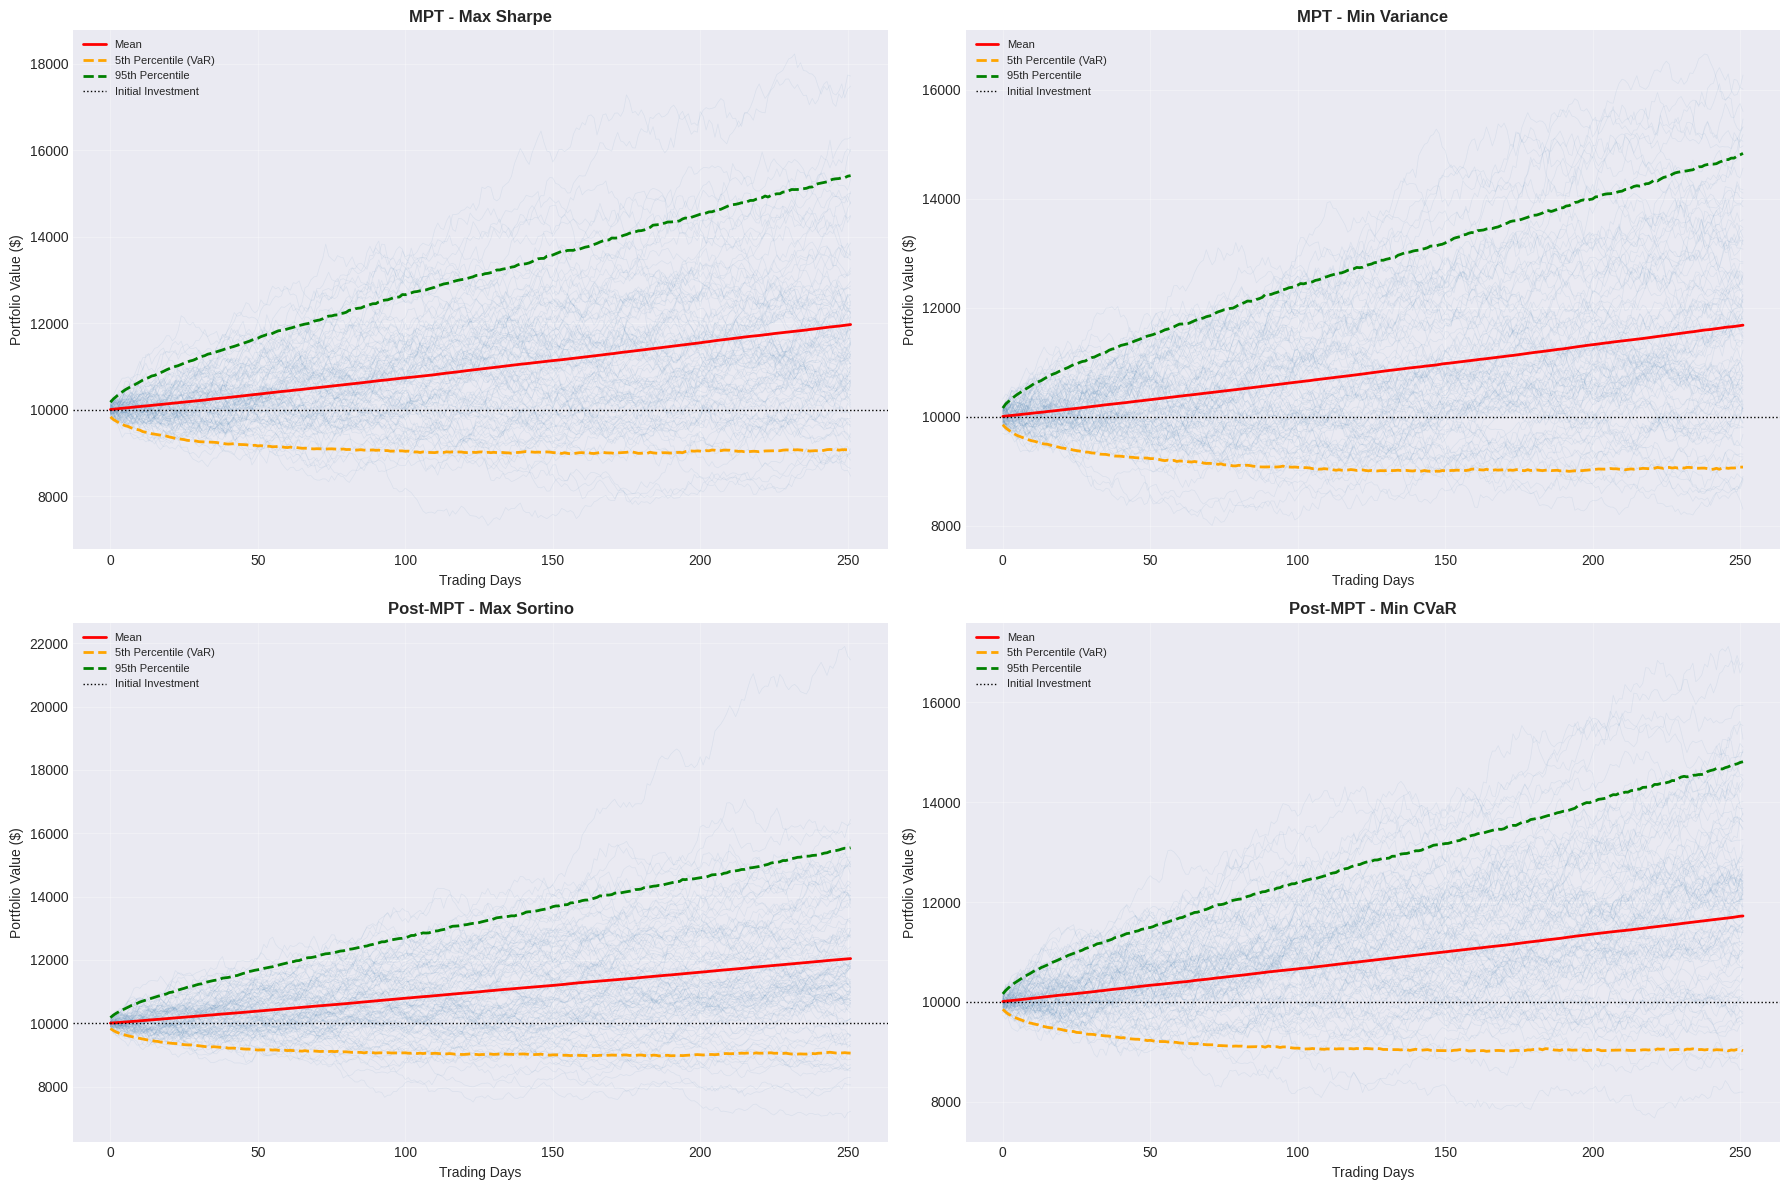

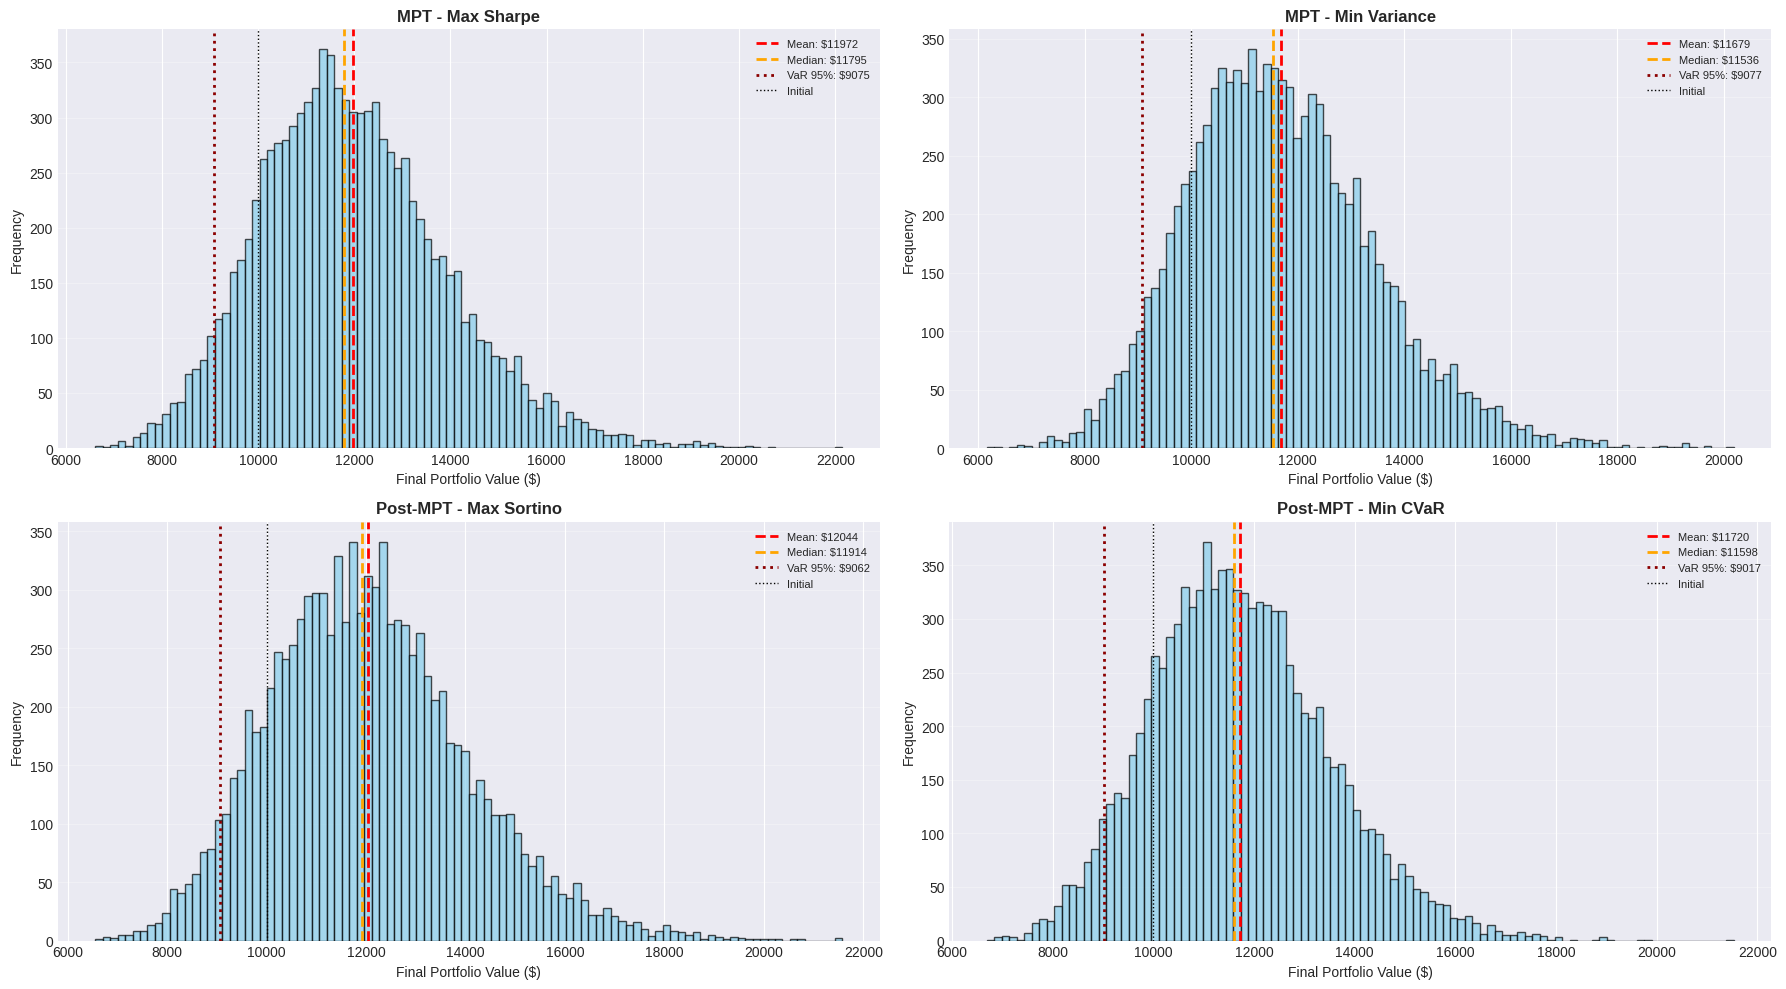

In [16]:
# Plot simulation paths
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

for idx, (portfolio_name, data) in enumerate(simulation_results.items()):
    ax = axes[idx // 2, idx % 2]
    sims = data['simulations']
    
    # Plot sample paths
    for i in range(100):  # Plot 100 sample paths
        ax.plot(sims[:, i], alpha=0.1, color='steelblue', linewidth=0.5)
    
    # Plot mean and percentiles
    mean_path = np.mean(sims, axis=1)
    p5 = np.percentile(sims, 5, axis=1)
    p95 = np.percentile(sims, 95, axis=1)
    
    ax.plot(mean_path, color='red', linewidth=2, label='Mean')
    ax.plot(p5, color='orange', linewidth=2, linestyle='--', label='5th Percentile (VaR)')
    ax.plot(p95, color='green', linewidth=2, linestyle='--', label='95th Percentile')
    ax.axhline(y=initial_investment, color='black', linestyle=':', linewidth=1, label='Initial Investment')
    
    ax.set_title(portfolio_name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Trading Days', fontsize=10)
    ax.set_ylabel('Portfolio Value ($)', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('monte_carlo_simulations.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot final value distributions
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

for idx, (portfolio_name, data) in enumerate(simulation_results.items()):
    ax = axes[idx // 2, idx % 2]
    final_values = data['final_values']
    results = data['results']
    
    ax.hist(final_values, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
    ax.axvline(x=results['Mean Final Value'], color='red', linestyle='--', linewidth=2, label=f"Mean: ${results['Mean Final Value']:.0f}")
    ax.axvline(x=results['Median Final Value'], color='orange', linestyle='--', linewidth=2, label=f"Median: ${results['Median Final Value']:.0f}")
    ax.axvline(x=results['VaR 95%'], color='darkred', linestyle=':', linewidth=2, label=f"VaR 95%: ${results['VaR 95%']:.0f}")
    ax.axvline(x=initial_investment, color='black', linestyle=':', linewidth=1, label='Initial')
    
    ax.set_title(portfolio_name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Final Portfolio Value ($)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('final_value_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## Phase 5: Final Evaluation & Comparison

FINAL PORTFOLIO COMPARISON - MONTE CARLO SIMULATION RESULTS
             Portfolio  Mean Final Value  Median Final Value     Std Dev  Mean Return (%)  Median Return (%)     VaR 95%    CVaR 95%    Best Case  Worst Case  Probability of Profit (%)
      MPT - Max Sharpe      11971.657451        11795.452125 1944.286751        19.716575          17.954521 9075.103573 8485.812976 22144.278859 6612.726411                      85.41
    MPT - Min Variance      11678.911366        11536.425351 1754.576615        16.789114          15.364254 9076.540324 8514.480520 20185.914742 6166.447602                      83.60
Post-MPT - Max Sortino      12044.142132        11914.376884 1983.629903        20.441421          19.143769 9061.934732 8474.898839 21573.616549 6555.172292                      85.31
   Post-MPT - Min CVaR      11719.869113        11598.466135 1754.632518        17.198691          15.984661 9016.711253 8483.925544 21534.665486 6689.504347                      84.21


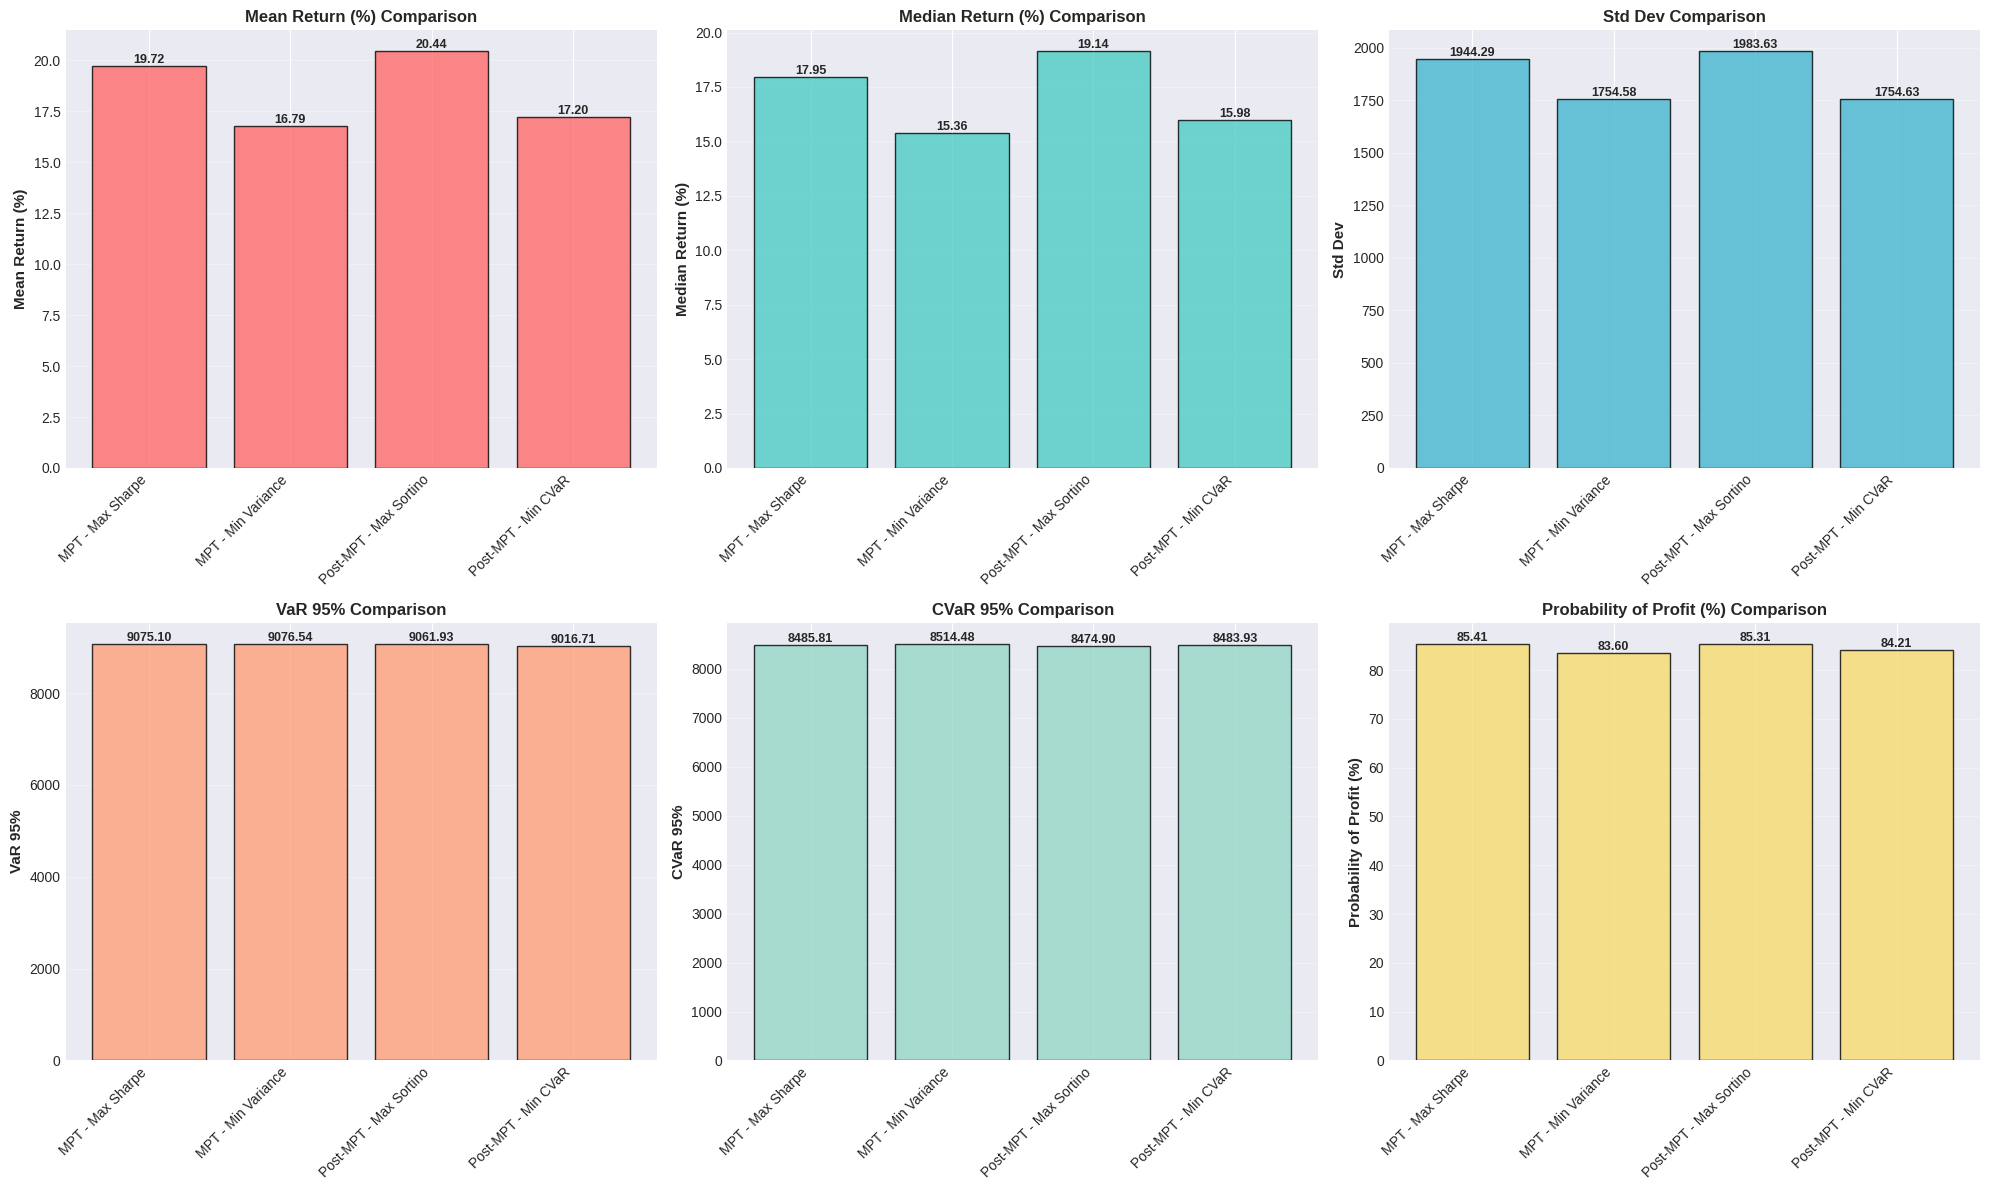


PORTFOLIO RANKINGS
Highest Mean Return: Post-MPT - Max Sortino
Highest Median Return: Post-MPT - Max Sortino
Lowest Risk (Std Dev): MPT - Min Variance
Best VaR (95%): MPT - Min Variance
Best CVaR (95%): MPT - Min Variance
Highest Probability of Profit: MPT - Max Sharpe

🏆 BEST OVERALL (Risk-Adjusted Return): Post-MPT - Max Sortino
   Return: 20.44%
   Risk-Adjusted Score: 1.0305

SUMMARY
✓ Analyzed 150 oldest stocks (1980-2022)
✓ Trained 5 prediction models (LR, LSTM, Transformer, Black-Scholes, Hybrid)
✓ Optimized 4 portfolios (2 MPT + 2 Post-MPT)
✓ Ran 10,000 Monte Carlo simulations per portfolio
✓ Initial investment: $10,000
✓ Simulation period: 252 trading days (1 year)

RECOMMENDATION:
For maximizing risk-adjusted returns: Post-MPT - Max Sortino
For maximizing raw returns: Post-MPT - Max Sortino
For minimizing risk: MPT - Min Variance

✓ Portfolio optimization and simulation complete!


In [17]:
# Create comprehensive comparison table
comparison_df = pd.DataFrame(all_results)

print("=" * 100)
print("FINAL PORTFOLIO COMPARISON - MONTE CARLO SIMULATION RESULTS")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Bar charts for key metrics
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

metrics = ['Mean Return (%)', 'Median Return (%)', 'Std Dev', 'VaR 95%', 'CVaR 95%', 'Probability of Profit (%)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    ax.bar(comparison_df['Portfolio'], comparison_df[metric], color=colors[idx], alpha=0.8, edgecolor='black')
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add value labels
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('portfolio_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Determine best portfolio
print("\n" + "=" * 100)
print("PORTFOLIO RANKINGS")
print("=" * 100)

# Rank by different criteria
rankings = {
    'Highest Mean Return': comparison_df.loc[comparison_df['Mean Return (%)'].idxmax(), 'Portfolio'],
    'Highest Median Return': comparison_df.loc[comparison_df['Median Return (%)'].idxmax(), 'Portfolio'],
    'Lowest Risk (Std Dev)': comparison_df.loc[comparison_df['Std Dev'].idxmin(), 'Portfolio'],
    'Best VaR (95%)': comparison_df.loc[comparison_df['VaR 95%'].idxmax(), 'Portfolio'],
    'Best CVaR (95%)': comparison_df.loc[comparison_df['CVaR 95%'].idxmax(), 'Portfolio'],
    'Highest Probability of Profit': comparison_df.loc[comparison_df['Probability of Profit (%)'].idxmax(), 'Portfolio']
}

for criterion, winner in rankings.items():
    print(f"{criterion}: {winner}")

# Calculate risk-adjusted return (Sharpe-like metric from simulation)
comparison_df['Risk_Adjusted_Return'] = comparison_df['Mean Return (%)'] / (comparison_df['Std Dev'] / initial_investment * 100)
best_risk_adjusted = comparison_df.loc[comparison_df['Risk_Adjusted_Return'].idxmax(), 'Portfolio']

print(f"\n🏆 BEST OVERALL (Risk-Adjusted Return): {best_risk_adjusted}")
print(f"   Return: {comparison_df.loc[comparison_df['Risk_Adjusted_Return'].idxmax(), 'Mean Return (%)']:.2f}%")
print(f"   Risk-Adjusted Score: {comparison_df.loc[comparison_df['Risk_Adjusted_Return'].idxmax(), 'Risk_Adjusted_Return']:.4f}")

print("\n" + "=" * 100)
print("SUMMARY")
print("=" * 100)
print(f"✓ Analyzed 150 oldest stocks (1980-2022)")
print(f"✓ Trained 5 prediction models (LR, LSTM, Transformer, Black-Scholes, Hybrid)")
print(f"✓ Optimized 4 portfolios (2 MPT + 2 Post-MPT)")
print(f"✓ Ran {num_simulations:,} Monte Carlo simulations per portfolio")
print(f"✓ Initial investment: ${initial_investment:,}")
print(f"✓ Simulation period: {num_days} trading days (1 year)")
print("\nRECOMMENDATION:")
print(f"For maximizing risk-adjusted returns: {best_risk_adjusted}")
print(f"For maximizing raw returns: {rankings['Highest Mean Return']}")
print(f"For minimizing risk: {rankings['Lowest Risk (Std Dev)']}")

print("\n✓ Portfolio optimization and simulation complete!")